**Required libraries**

In [0]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.preprocessing import binarize, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.calibration import calibration_curve

import matplotlib.pyplot as plt

**Functions**

In [0]:
def encoder(dataset, catFeatures, qtyFeatures):
  dataset = dataset[catFeatures + qtyFeatures]
  dataset_encoded = pd.get_dummies(dataset, 
                                   columns = catFeatures, 
                                   drop_first = True)
  
  return(dataset_encoded)

def plot_auc_curve(model, X, y):
  try:
      y_pred_prob = model.predict_proba(X)[:,1]
  except:
    d = model.decision_function(X)
    y_pred_prob = np.exp(d) / (1 + np.exp(d))
  
  auc = roc_auc_score(y, y_pred_prob)
  fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
  
  plt.plot(fpr, tpr)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.title('ROC Curve\n AUC={auc}'.format(auc = auc))
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.grid(True)

def model_training(model, X, y):
  model.fit(X,y)
  
  return(model)

def print_accurcay_metrics(model, X, y, threshold):
  try:
      y_pred_prob = model.predict_proba(X)[:,1]
  except:
    d = model.decision_function(X)
    y_pred_prob = np.exp(d) / (1 + np.exp(d))
  y_pred_class = binarize([y_pred_prob], threshold)[0]
  
  print("Accurcay:", accuracy_score(y, y_pred_class))
  print("AUC:", roc_auc_score(y, y_pred_prob))
  print("Log Loss:", log_loss(y, y_pred_prob))
  print("Confusion Matrix:\n", confusion_matrix(y, y_pred_class))
  print("Recall:", recall_score(y, y_pred_class))
  print("Precision:", precision_score(y, y_pred_class))


def Find_Optimal_Cutoff(model, X, y):
  try:
    y_pred_prob = model.predict_proba(X)[:,1]
  except:
    d = model.decision_function(X)
    y_pred_prob = np.exp(d) / (1 + np.exp(d))
    
  fpr, tpr, threshold = roc_curve(y, y_pred_prob)
  i = np.arange(len(tpr)) 
  roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
  roc_t = roc.loc[(roc.tf-0).abs().argsort()[:1]]
  
  print("Optimal Cutoff:", roc_t['threshold'].values)
  return(roc_t['threshold'].values)
  
def feature_importance(model, X):
  importances = model.feature_importances_
  std = np.std([tree.feature_importances_ for tree in model.estimators_],
               axis=0)
  indices = np.argsort(importances)[::-1]

  # Print the feature ranking
  print("Feature ranking:")

  for f in range(X.shape[1]):
      print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

  # Plot the feature importances of the forest
  plt.figure()
  plt.title("Feature importances")
  plt.bar(range(X.shape[1]), importances[indices],
          color="r", yerr=std[indices], align="center")
  plt.xticks(range(X.shape[1]), indices)
  plt.xlim([-1, X.shape[1]])
  plt.show()

# Plot calibration plots
def plot_calibration(y_true, y_prob, n_bins, model_name):
  plt.figure(figsize=(10, 10))
  ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
  ax2 = plt.subplot2grid((3, 1), (2, 0))

  ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
  fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_true, y_prob, n_bins=n_bins)

  ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (model_name, ))

  ax2.hist(y_pred_prob, range=(0, 1), bins=10, label=model_name,
             histtype="step", lw=2)

  ax1.set_ylabel("Fraction of positives")
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend(loc="lower right")
  ax1.set_title('Calibration plots')

  ax2.set_xlabel("Mean predicted value")
  ax2.set_ylabel("Count")
  ax2.legend(loc="upper right", ncol=2)

  plt.tight_layout()
  plt.show()

**Confusion Matrix**
*   first argument is actual values, second argument is predicted values

**Precision:**
*  When a positive value is predicted, how often is the prediction correct?
*  How "precise" is the classifier when predicting positive instances?

**Recall**
*   Calculate TP rate or recall



**Pandas**
*   use the pandas library to read data into Python


In [0]:
file_url ='https://drive.google.com/uc?export=download&id=13YvNpCckww8rNdLGxAh0tekdsehXI0HU'
df = pd.read_csv(file_url)



Use the head method to display the first 5 rows

In [0]:
df.head()

,Loan_ID,Customer_ID,Loan_Status,Current_Loan_Amount,Term,Credit_Score,Years_in_current_job,Home_Ownership,Annual_Income,Purpose,Monthly_Debt,Years_of_Credit_History,Months_since_last_delinquent,Number_of_Open_Accounts,Number_of_Credit_Problems,Current_Credit_Balance,Maximum_Open_Credit,Bankruptcies,Tax_Liens
0,6cf51492-02a2-423e-b93d-676f05b9ad53,7c202b37-2add-44e8-9aea-d5b119aea935,Charged Off,12232,Short Term,7280.0,< 1 year,Rent,46643.0,Debt Consolidation,777.39,18.0,10.0,12,0,6762,7946,0.0,0.0
1,552e7ade-4292-4354-9ff9-c48031697d72,e7217b0a-07ac-47dd-b379-577b5a35b7c6,Charged Off,25014,Long Term,7330.0,10+ years,Home Mortgage,81099.0,Debt Consolidation,892.09,26.7,NaN,14,0,35706,77961,0.0,0.0
2,9b5e32b3-8d76-4801-afc8-d729d5a2e6b9,0a62fc41-16c8-40b5-92ff-9e4b763ce714,Charged Off,16117,Short Term,7240.0,9 years,Home Mortgage,60438.0,Home Improvements,"1,244.02",16.7,32.0,11,1,11275,14815,1.0,0.0
3,5419b7c7-ac11-4be2-a8a7-b131fb6d6dbe,30f36c59-5182-4482-8bbb-5b736849ae43,Charged Off,11716,Short Term,7400.0,3 years,Rent,34171.0,Debt Consolidation,990.94,10.0,NaN,21,0,7009,43533,0.0,0.0
4,1450910f-9495-4fc9-afaf-9bdf4b9821df,70c26012-bba5-42c0-8dcb-75295ada31bb,Charged Off,9789,Long Term,6860.0,10+ years,Home Mortgage,47003.0,Home Improvements,503.71,16.7,25.0,13,1,16913,19553,1.0,0.0


check the shape of the DataFrame (rows, columns)

In [0]:
df.shape

(111105, 19)

In [0]:
df.dtypes

Loan_ID                          object
Customer_ID                      object
Loan_Status                      object
Current_Loan_Amount               int64
Term                             object
Credit_Score                    float64
Years_in_current_job             object
Home_Ownership                   object
Annual_Income                   float64
Purpose                          object
Monthly_Debt                     object
Years_of_Credit_History         float64
Months_since_last_delinquent    float64
Number_of_Open_Accounts           int64
Number_of_Credit_Problems         int64
Current_Credit_Balance            int64
Maximum_Open_Credit               int64
Bankruptcies                    float64
Tax_Liens                       float64
dtype: object

Use the describe method to generates descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values

In [0]:
df.describe()

,Current_Loan_Amount,Credit_Score,Annual_Income,Years_of_Credit_History,Months_since_last_delinquent,Number_of_Open_Accounts,Number_of_Credit_Problems,Current_Credit_Balance,Maximum_Open_Credit,Bankruptcies,Tax_Liens
count,1.111050e+05,89768.000000,8.976800e+04,111105.000000,52102.000000,111105.000000,111105.000000,1.111050e+05,1.111050e+05,110877.000000,111094.000000
mean,1.147739e+07,1075.728701,7.248575e+04,18.200991,34.902403,11.125197,0.168030,1.548342e+04,3.438644e+04,0.117662,0.029354
std,3.185533e+07,1474.007753,5.593120e+04,7.014542,21.971081,5.010249,0.484216,1.982122e+04,3.643027e+05,0.351423,0.260577
min,4.910000e+02,585.000000,4.033000e+03,3.600000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,8.162000e+03,705.000000,4.468750e+04,13.500000,16.000000,8.000000,0.000000,5.905000e+03,1.241700e+04,0.000000,0.000000
50%,1.418300e+04,724.000000,6.175200e+04,16.900000,32.000000,10.000000,0.000000,1.102700e+04,2.124300e+04,0.000000,0.000000
75%,2.382200e+04,741.000000,8.688700e+04,21.700000,51.000000,14.000000,0.000000,1.933800e+04,3.558400e+04,0.000000,0.000000
max,1.000000e+08,7510.000000,8.713547e+06,70.500000,176.000000,76.000000,15.000000,1.730472e+06,6.998809e+07,7.000000,15.000000


In [0]:
df.loc[((df['Credit_Score'] > 850) & 
        (df['Credit_Score'] < 300)), 'Credit_Score'] = np.nan

Count the number of NA values for each variable

In [0]:
df.isnull().sum()

Loan_ID                             0
Customer_ID                         0
Loan_Status                         0
Current_Loan_Amount                 0
Term                                0
Credit_Score                    21337
Years_in_current_job             4693
Home_Ownership                      0
Annual_Income                   21337
Purpose                             0
Monthly_Debt                        0
Years_of_Credit_History             0
Months_since_last_delinquent    59003
Number_of_Open_Accounts             0
Number_of_Credit_Problems           0
Current_Credit_Balance              0
Maximum_Open_Credit                 0
Bankruptcies                      228
Tax_Liens                          11
dtype: int64

Number of examples per class

In [0]:
df.groupby('Loan_Status')['Loan_ID'].count()

Loan_Status
Charged Off    25171
Fully Paid     85934
Name: Loan_ID, dtype: int64

In [0]:
loanIDCount = df.groupby('Loan_ID')['Loan_Status'].count()
loanIDCount = loanIDCount.sort_values(ascending = False)
loanIDCount[0:5]

Loan_ID
ffffe32e-ed17-459f-9cfd-7b9ee7972933    2
88d3401f-4934-4b07-9b2a-c77e6d891a26    2
88e10a17-6ff8-418e-8b9b-90dfcc7a1172    2
88df68fb-a7cc-4d0d-8c31-1ecd4a743ed1    2
88dbd104-4b77-4450-a77c-402d090789bb    2
Name: Loan_Status, dtype: int64

In [0]:
df[df['Loan_ID'] == 'ffffe32e-ed17-459f-9cfd-7b9ee7972933']

,Loan_ID,Customer_ID,Loan_Status,Current_Loan_Amount,Term,Credit_Score,Years_in_current_job,Home_Ownership,Annual_Income,Purpose,Monthly_Debt,Years_of_Credit_History,Months_since_last_delinquent,Number_of_Open_Accounts,Number_of_Credit_Problems,Current_Credit_Balance,Maximum_Open_Credit,Bankruptcies,Tax_Liens
78728,ffffe32e-ed17-459f-9cfd-7b9ee7972933,97281336-1e45-41d2-acb2-263ce56a590e,Fully Paid,27902,Long Term,678.0,10+ years,Home Mortgage,117480.0,Debt Consolidation,"2,525.82",18.0,11.0,10,0,28317,62371,0.0,0.0
111027,ffffe32e-ed17-459f-9cfd-7b9ee7972933,97281336-1e45-41d2-acb2-263ce56a590e,Fully Paid,27902,Long Term,678.0,10+ years,Home Mortgage,117480.0,Debt Consolidation,"2,525.82",18.0,11.0,10,0,28317,62371,0.0,0.0


In [0]:
df.drop_duplicates(inplace = True)

In [0]:
df.shape

(98579, 19)

In [0]:
loanIDCount = df.groupby('Loan_ID')['Loan_Status'].count()
loanIDCount = loanIDCount.sort_values(ascending = False)
loanIDCount[0:5]

Loan_ID
7f85733b-ef51-48e5-a0a2-1a7b68492d4e    2
c222319b-6c06-4f6c-a8ef-897d61bd50b9    2
c248962c-f1b5-4804-ab83-22013a7c0e3c    2
3672cd35-b4aa-4252-99a3-a182ca10dbd9    2
c23c8b4a-7106-4d2a-bffd-ca1d47ff517f    2
Name: Loan_Status, dtype: int64

In [0]:
df[df['Loan_ID'] == '7f85733b-ef51-48e5-a0a2-1a7b68492d4e']

,Loan_ID,Customer_ID,Loan_Status,Current_Loan_Amount,Term,Credit_Score,Years_in_current_job,Home_Ownership,Annual_Income,Purpose,Monthly_Debt,Years_of_Credit_History,Months_since_last_delinquent,Number_of_Open_Accounts,Number_of_Credit_Problems,Current_Credit_Balance,Maximum_Open_Credit,Bankruptcies,Tax_Liens
27947,7f85733b-ef51-48e5-a0a2-1a7b68492d4e,bc89f7d9-b603-41ee-9497-a40752183ae9,Fully Paid,11887,Short Term,NaN,4 years,Home Mortgage,NaN,Debt Consolidation,"1,287.70",16.6,26.0,11,0,32953,35471,0.0,0.0
100165,7f85733b-ef51-48e5-a0a2-1a7b68492d4e,bc89f7d9-b603-41ee-9497-a40752183ae9,Fully Paid,11887,Short Term,701.0,4 years,Home Mortgage,188214.0,Debt Consolidation,"1,287.70",16.6,26.0,11,0,32953,35471,0.0,0.0


In [0]:
df['naCount'] = df.isnull().sum(axis=1)

In [0]:
df.head()

,Loan_ID,Customer_ID,Loan_Status,Current_Loan_Amount,Term,Credit_Score,Years_in_current_job,Home_Ownership,Annual_Income,Purpose,Monthly_Debt,Years_of_Credit_History,Months_since_last_delinquent,Number_of_Open_Accounts,Number_of_Credit_Problems,Current_Credit_Balance,Maximum_Open_Credit,Bankruptcies,Tax_Liens,naCount
0,6cf51492-02a2-423e-b93d-676f05b9ad53,7c202b37-2add-44e8-9aea-d5b119aea935,Charged Off,12232,Short Term,7280.0,< 1 year,Rent,46643.0,Debt Consolidation,777.39,18.0,10.0,12,0,6762,7946,0.0,0.0,0
1,552e7ade-4292-4354-9ff9-c48031697d72,e7217b0a-07ac-47dd-b379-577b5a35b7c6,Charged Off,25014,Long Term,7330.0,10+ years,Home Mortgage,81099.0,Debt Consolidation,892.09,26.7,NaN,14,0,35706,77961,0.0,0.0,1
2,9b5e32b3-8d76-4801-afc8-d729d5a2e6b9,0a62fc41-16c8-40b5-92ff-9e4b763ce714,Charged Off,16117,Short Term,7240.0,9 years,Home Mortgage,60438.0,Home Improvements,"1,244.02",16.7,32.0,11,1,11275,14815,1.0,0.0,0
3,5419b7c7-ac11-4be2-a8a7-b131fb6d6dbe,30f36c59-5182-4482-8bbb-5b736849ae43,Charged Off,11716,Short Term,7400.0,3 years,Rent,34171.0,Debt Consolidation,990.94,10.0,NaN,21,0,7009,43533,0.0,0.0,1
4,1450910f-9495-4fc9-afaf-9bdf4b9821df,70c26012-bba5-42c0-8dcb-75295ada31bb,Charged Off,9789,Long Term,6860.0,10+ years,Home Mortgage,47003.0,Home Improvements,503.71,16.7,25.0,13,1,16913,19553,1.0,0.0,0


In [0]:
df.sort_values(by=['Loan_ID', 'naCount'], inplace = True)

In [0]:
df.drop_duplicates(subset=['Loan_ID'], keep = 'first', inplace = True)

In [0]:
loanIDCount = df.groupby('Loan_ID')['Loan_Status'].count()
loanIDCount = loanIDCount.sort_values(ascending = False)
loanIDCount[0:5]

Loan_ID
ffffe32e-ed17-459f-9cfd-7b9ee7972933    1
54ed190f-d7d5-47b9-893f-33520c1e3523    1
54e81c12-0081-4634-b13b-28c097819d91    1
54e8432d-4bec-480d-a05c-904210d4ad36    1
54e885ba-2507-44ab-afb4-50ed5ae2d1e5    1
Name: Loan_Status, dtype: int64

In [0]:
print(len(df['Loan_ID'].unique()))
print(df.shape)

88908
(88908, 20)


In [0]:
df.isnull().sum()

Loan_ID                             0
Customer_ID                         0
Loan_Status                         0
Current_Loan_Amount                 0
Term                                0
Credit_Score                    16088
Years_in_current_job             3817
Home_Ownership                      0
Annual_Income                   16088
Purpose                             0
Monthly_Debt                        0
Years_of_Credit_History             0
Months_since_last_delinquent    48506
Number_of_Open_Accounts             0
Number_of_Credit_Problems           0
Current_Credit_Balance              0
Maximum_Open_Credit                 0
Bankruptcies                      192
Tax_Liens                           8
naCount                             0
dtype: int64

In [0]:
df.describe()

,Current_Loan_Amount,Credit_Score,Annual_Income,Years_of_Credit_History,Months_since_last_delinquent,Number_of_Open_Accounts,Number_of_Credit_Problems,Current_Credit_Balance,Maximum_Open_Credit,Bankruptcies,Tax_Liens,naCount
count,8.890800e+04,72820.000000,7.282000e+04,88908.000000,40402.000000,88908.000000,88908.000000,8.890800e+04,8.890800e+04,88716.000000,88900.000000,88908.000000
mean,1.433911e+07,1163.139371,7.240451e+04,18.315301,35.080466,11.110463,0.160480,1.543628e+04,3.596531e+04,0.112674,0.028223,0.952659
std,3.503029e+07,1624.120461,5.771389e+04,7.049233,22.009079,4.978438,0.473751,1.965881e+04,4.041805e+05,0.343303,0.257536,0.949000
min,4.910000e+02,585.000000,4.033000e+03,3.600000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,8.284500e+03,711.000000,4.463750e+04,13.500000,16.000000,8.000000,0.000000,5.949000e+03,1.277500e+04,0.000000,0.000000,0.000000
50%,1.435500e+04,731.000000,6.158500e+04,17.000000,32.000000,10.000000,0.000000,1.103900e+04,2.178100e+04,0.000000,0.000000,1.000000
75%,2.448550e+04,743.000000,8.678500e+04,21.800000,51.000000,14.000000,0.000000,1.930100e+04,3.636700e+04,0.000000,0.000000,1.000000
max,1.000000e+08,7510.000000,8.713547e+06,70.500000,176.000000,76.000000,15.000000,1.730472e+06,6.998809e+07,7.000000,15.000000,5.000000


In [0]:
df.dtypes

Loan_ID                          object
Customer_ID                      object
Loan_Status                      object
Current_Loan_Amount               int64
Term                             object
Credit_Score                    float64
Years_in_current_job             object
Home_Ownership                   object
Annual_Income                   float64
Purpose                          object
Monthly_Debt                     object
Years_of_Credit_History         float64
Months_since_last_delinquent    float64
Number_of_Open_Accounts           int64
Number_of_Credit_Problems         int64
Current_Credit_Balance            int64
Maximum_Open_Credit               int64
Bankruptcies                    float64
Tax_Liens                       float64
naCount                           int64
dtype: object

In [0]:
yearsInCurrentJobCount = df.groupby('Years_in_current_job')['Loan_ID'].count()
yearsInCurrentJobCount = yearsInCurrentJobCount.sort_values(ascending = False)
yearsInCurrentJobCount

Years_in_current_job
10+ years    27409
2 years       8186
< 1 year      7312
3 years       7263
5 years       6084
1 year        5765
4 years       5474
6 years       5095
7 years       4943
8 years       4098
9 years       3462
Name: Loan_ID, dtype: int64

In [0]:
df.loc[(df['Years_in_current_job'] == '< 1 year'), 'Years_in_current_job'] = 0.5
df.loc[(df['Years_in_current_job'] == '1 year'), 'Years_in_current_job'] = 1
df.loc[(df['Years_in_current_job'] == '2 years'), 'Years_in_current_job'] = 2
df.loc[(df['Years_in_current_job'] == '3 years'), 'Years_in_current_job'] = 3
df.loc[(df['Years_in_current_job'] == '4 years'), 'Years_in_current_job'] = 4
df.loc[(df['Years_in_current_job'] == '5 years'), 'Years_in_current_job'] = 5
df.loc[(df['Years_in_current_job'] == '6 years'), 'Years_in_current_job'] = 6
df.loc[(df['Years_in_current_job'] == '7 years'), 'Years_in_current_job'] = 7
df.loc[(df['Years_in_current_job'] == '8 years'), 'Years_in_current_job'] = 8
df.loc[(df['Years_in_current_job'] == '9 years'), 'Years_in_current_job'] = 9
df.loc[(df['Years_in_current_job'] == '10+ years'), 'Years_in_current_job'] = 10

In [0]:
df['Years_in_current_job'] = df['Years_in_current_job'].astype('float')

In [0]:
monthlyDebtCount = df.groupby('Monthly_Debt')['Loan_ID'].count()
monthlyDebtCount = monthlyDebtCount.sort_values(ascending = False)
monthlyDebtCount

Monthly_Debt
0           69
775.08       8
984.75       7
560.42       7
837          7
807.53       6
657.74       6
621.92       6
705.49       6
682.5        6
570.8        6
901.69       5
835.83       5
399.17       5
996.11       5
693.67       5
765          5
934.23       5
591.36       5
723.42       5
576.84       5
423.28       5
476.71       5
1,223.64     5
1,046.12     5
1,042.03     5
638.94       5
441.78       5
1,001.18     5
582.07       5
            ..
439.84       1
439.89       1
440.26       1
439.98       1
440.24       1
440.21       1
440.15       1
440.13       1
440.12       1
440.11       1
440.08       1
440.06       1
440.04       1
440.01       1
44.95        1
44.74        1
44.64        1
44.61        1
44.56        1
44.55        1
44.49        1
44.46        1
44.38        1
44.21        1
44.18        1
44.14        1
44.12        1
44.1         1
44.03        1
3,050.82     1
Name: Loan_ID, Length: 70063, dtype: int64

Convert number strings with commas to float

In [0]:
df["Monthly_Debt"] = df["Monthly_Debt"].str.replace(",","").astype(float)
df['Monthly_Debt'] = df['Monthly_Debt'].astype('float')


In [0]:
df.dtypes

Loan_ID                          object
Customer_ID                      object
Loan_Status                      object
Current_Loan_Amount               int64
Term                             object
Credit_Score                    float64
Years_in_current_job            float64
Home_Ownership                   object
Annual_Income                   float64
Purpose                          object
Monthly_Debt                    float64
Years_of_Credit_History         float64
Months_since_last_delinquent    float64
Number_of_Open_Accounts           int64
Number_of_Credit_Problems         int64
Current_Credit_Balance            int64
Maximum_Open_Credit               int64
Bankruptcies                    float64
Tax_Liens                       float64
naCount                           int64
dtype: object

In [0]:
df.isnull().sum()

Loan_ID                             0
Customer_ID                         0
Loan_Status                         0
Current_Loan_Amount                 0
Term                                0
Credit_Score                    16088
Years_in_current_job             3817
Home_Ownership                      0
Annual_Income                   16088
Purpose                             0
Monthly_Debt                        0
Years_of_Credit_History             0
Months_since_last_delinquent    48506
Number_of_Open_Accounts             0
Number_of_Credit_Problems           0
Current_Credit_Balance              0
Maximum_Open_Credit                 0
Bankruptcies                      192
Tax_Liens                           8
naCount                             0
dtype: int64

Fill in missing values with mean

In [0]:
for f in ['Credit_Score', 
          'Years_in_current_job', 
          'Annual_Income', 
          'Months_since_last_delinquent',
          'Bankruptcies', 'Tax_Liens']:
  df.loc[df[f].isnull(), f] = df[f].mean()


In [0]:
df.isnull().sum()

Loan_ID                         0
Customer_ID                     0
Loan_Status                     0
Current_Loan_Amount             0
Term                            0
Credit_Score                    0
Years_in_current_job            0
Home_Ownership                  0
Annual_Income                   0
Purpose                         0
Monthly_Debt                    0
Years_of_Credit_History         0
Months_since_last_delinquent    0
Number_of_Open_Accounts         0
Number_of_Credit_Problems       0
Current_Credit_Balance          0
Maximum_Open_Credit             0
Bankruptcies                    0
Tax_Liens                       0
naCount                         0
dtype: int64

In [0]:
df.dtypes

Loan_ID                          object
Customer_ID                      object
Loan_Status                      object
Current_Loan_Amount               int64
Term                             object
Credit_Score                    float64
Years_in_current_job            float64
Home_Ownership                   object
Annual_Income                   float64
Purpose                          object
Monthly_Debt                    float64
Years_of_Credit_History         float64
Months_since_last_delinquent    float64
Number_of_Open_Accounts           int64
Number_of_Credit_Problems         int64
Current_Credit_Balance            int64
Maximum_Open_Credit               int64
Bankruptcies                    float64
Tax_Liens                       float64
naCount                           int64
dtype: object

In [0]:
qtyFeatures = ['Current_Loan_Amount', 
               'Credit_Score', 'Years_in_current_job', 
               'Annual_Income', 'Monthly_Debt', 
               'Years_of_Credit_History',
               'Months_since_last_delinquent', 'Number_of_Open_Accounts',
               'Current_Credit_Balance',
               'Maximum_Open_Credit', 
               'Number_of_Credit_Problems', 'Bankruptcies', 'Tax_Liens'
              ]

catFeatures = ['Term', 'Home_Ownership', 'Purpose']

label = 'Loan_Status'

In [0]:
df.groupby(['Home_Ownership'])['Loan_ID'].count()

Home_Ownership
HaveMortgage       170
Home Mortgage    43270
Own Home          8075
Rent             37393
Name: Loan_ID, dtype: int64

In [0]:
df.loc[(df['Home_Ownership'] == 'HaveMortgage'), 'Home_Ownership'] = 'Home Mortgage' 

In [0]:
df.groupby(['Term'])['Loan_ID'].count()

Term
Long Term     21978
Short Term    66930
Name: Loan_ID, dtype: int64

In [0]:
df.groupby(['Purpose'])['Loan_ID'].count()

Purpose
Business Loan            1328
Buy House                 559
Buy a Car                1196
Debt Consolidation      70445
Educational Expenses       92
Home Improvements        5206
Medical Bills             955
Other                    7767
Take a Trip               454
major_purchase            344
moving                    124
renewable_energy            9
small_business            248
vacation                   82
wedding                    99
Name: Loan_ID, dtype: int64

In [0]:
df.loc[(df['Purpose'] == 'other'), 'Purpose'] = 'Other' 

In [0]:
df['Loan_Status'].unique()

array(['Fully Paid', 'Charged Off'], dtype=object)

**Preparing X and y using pandas:**

In [0]:
X_encoded = encoder(df, catFeatures, qtyFeatures)

le = LabelEncoder()
y_encoded = le.fit_transform(df[label])

In [0]:
X_encoded.head()

,Current_Loan_Amount,Credit_Score,Years_in_current_job,Annual_Income,Monthly_Debt,Years_of_Credit_History,Months_since_last_delinquent,Number_of_Open_Accounts,Current_Credit_Balance,Maximum_Open_Credit,...,Purpose_Home Improvements,Purpose_Medical Bills,Purpose_Other,Purpose_Take a Trip,Purpose_major_purchase,Purpose_moving,Purpose_renewable_energy,Purpose_small_business,Purpose_vacation,Purpose_wedding
49725,11731,746.000000,4.0,50025.000000,355.18,11.5,35.080466,12,17391,37081,...,0,0,0,0,0,0,0,0,0,0
20733,24613,1163.139371,6.0,72404.505136,542.29,17.6,73.000000,7,14123,16954,...,0,0,0,0,0,0,0,0,0,0
15639,99999999,742.000000,3.0,64760.000000,582.84,26.8,35.080466,11,8880,22711,...,0,0,0,0,0,0,0,0,0,0
68632,11863,734.000000,10.0,69202.000000,859.26,30.3,35.080466,7,9959,16995,...,0,0,0,0,0,0,0,0,0,0
97429,13719,724.000000,1.0,34297.000000,777.38,13.6,2.000000,12,6720,53335,...,1,0,0,0,0,0,0,0,0,0


In [0]:
y_encoded

array([1, 0, 1, ..., 0, 1, 1])

Splitting X and y into training and testing sets

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, 
                                                    y_encoded, 
                                                    test_size = 0.2,
                                                    random_state = 1)

**Fit logistic regression**

Optimal Cutoff: [0.65119573]
Accurcay: 0.6536385108536723
AUC: 0.7259402394377812
Log Loss: 0.48491312540691517
Confusion Matrix:
 [[3090 1917]
 [4242 8533]]
Recall: 0.667945205479452
Precision: 0.8165550239234449


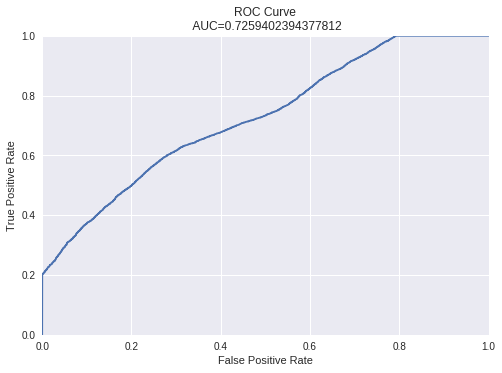

In [0]:
logreg = LogisticRegression()
model_training(logreg, X_train, y_train)

plot_auc_curve(logreg, X_test, y_test)
Find_Optimal_Cutoff(logreg, X_test, y_test)
print_accurcay_metrics(logreg, X_test, y_test, 0.65)

Optimal Cutoff: [0.65144076]
Accurcay: 0.650142001518432
AUC: 0.7198178626250189
Log Loss: 0.4933202962222927
Confusion Matrix:
 [[12358  7806]
 [17078 33884]]
Recall: 0.6648875632824457
Precision: 0.8127608539218037


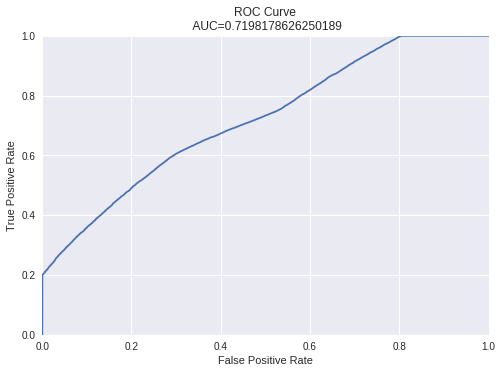

In [0]:
plot_auc_curve(logreg, X_train, y_train)
Find_Optimal_Cutoff(logreg, X_train, y_train)
print_accurcay_metrics(logreg, X_train, y_train, 0.65)

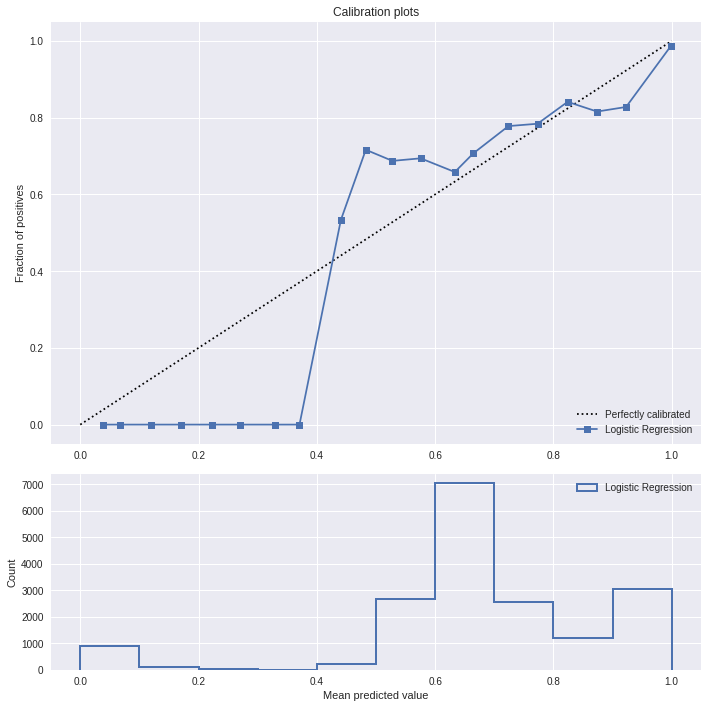

In [0]:
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

plot_calibration(y_test, y_pred_prob, 20, "Logistic Regression")

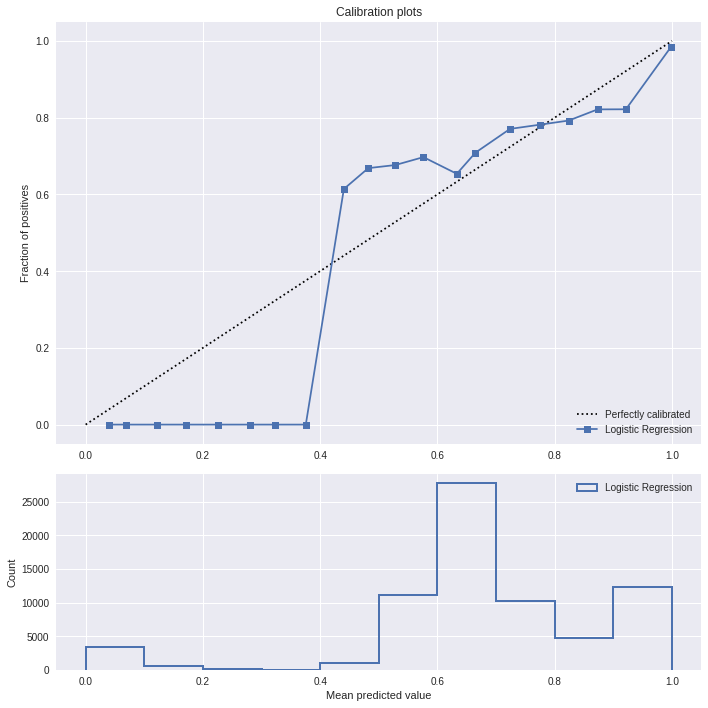

In [0]:
y_pred_prob = logreg.predict_proba(X_train)[:, 1]

plot_calibration(y_train, y_pred_prob, 20, "Logistic Regression")

In [0]:
print_accurcay_metrics(logreg, X_train, y_train, 0.65)

Accurcay: 0.650142001518432
AUC: 0.7198178626250189
Log Loss: 0.4933202962222927
Confusion Matrix:
 [[12358  7806]
 [17078 33884]]
Recall: 0.6648875632824457
Precision: 0.8127608539218037


**Fit Logistic regression with L2 regularization (Ridge)**

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.439214e-20
  overwrite_a=True).T


Optimal Cutoff: [0.61170703]
Accurcay: 0.6934540546620178
AUC: 0.7750788661040884
Log Loss: 0.5465331049892144
Confusion Matrix:
 [[3342 1665]
 [3786 8989]]
Recall: 0.7036399217221135
Precision: 0.8437206682935986


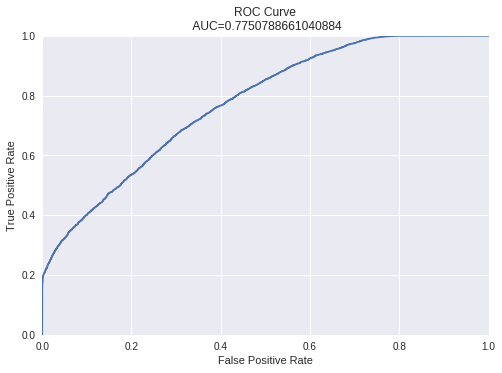

In [0]:
ridge = RidgeClassifier(alpha=1.0)
model_training(ridge, X_train, y_train)

plot_auc_curve(ridge, X_test, y_test)
Find_Optimal_Cutoff(ridge, X_test, y_test)
print_accurcay_metrics(ridge, X_test, y_test, 0.61)

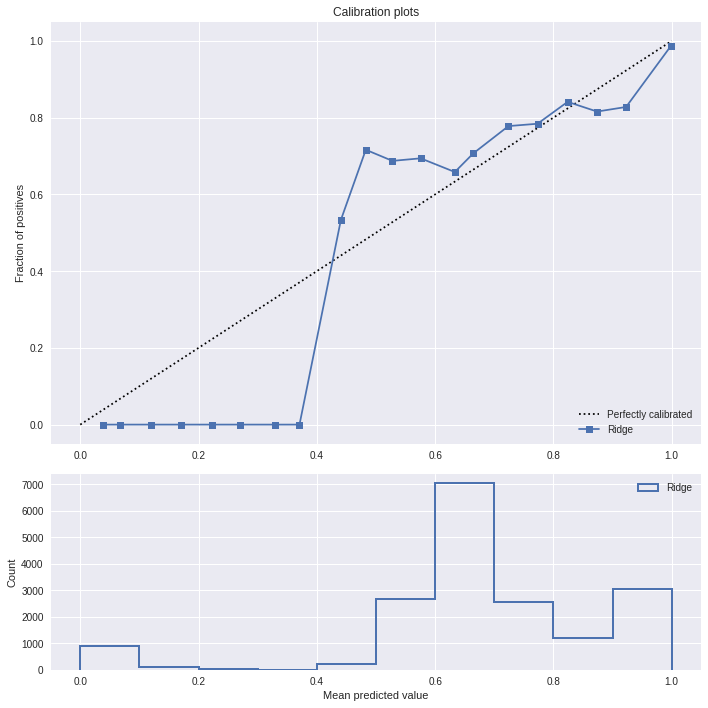

In [0]:
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

plot_calibration(y_test, y_pred_prob, 20, "Ridge")

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.570565e-20
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.120639e-20
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.346709e-20
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.079409e-20
  overwrite_a=True).T
/usr/local/lib/python3.6

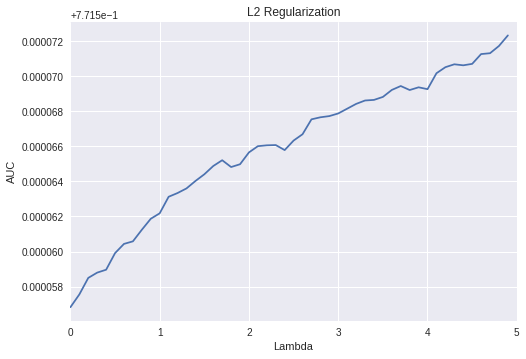

In [0]:
alpha_range = np.arange(0.001, 5, 0.1)
scores = []
for lam in alpha_range:
  ridge = RidgeClassifier(alpha=lam)
  scores.append(cross_val_score(ridge, X_train, y_train, cv=5, scoring='roc_auc').mean())

plt.plot(alpha_range, scores)
plt.xlim([0.0, 5])
#plt.ylim([0.0, 1.0])
plt.title('L2 Regularization')
plt.xlabel('Lambda')
plt.ylabel('AUC')
plt.grid(True)

In [0]:
scores

**Fit Logistic regression with L1 regularization (Lasso)**

Optimal Cutoff: [0.72814427]
Accurcay: 0.6831065122033517
AUC: 0.7805108855430187
Log Loss: 0.4462014466211261
Confusion Matrix:
 [[3472 1535]
 [4100 8675]]
Recall: 0.6790606653620352
Precision: 0.8496571988246817


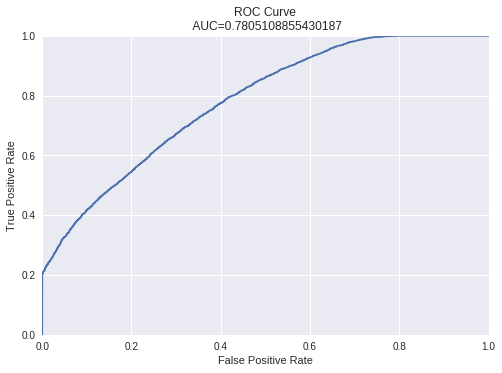

In [0]:
lasso = LogisticRegression(penalty='l1', C=1)
model_training(lasso, X_train, y_train)

plot_auc_curve(lasso, X_test, y_test)
Find_Optimal_Cutoff(lasso, X_test, y_test)
print_accurcay_metrics(lasso, X_test, y_test, 0.73)

In [0]:
lambda_range = np.arange(0.001, 5, 0.1)
scores = []
for lam in lambda_range:
  lasso = LogisticRegression(penalty='l1', C=1/lam)
  scores.append(cross_val_score(lasso, X_train, y_train, cv=5, scoring='roc_auc').mean())



NameError: ignored

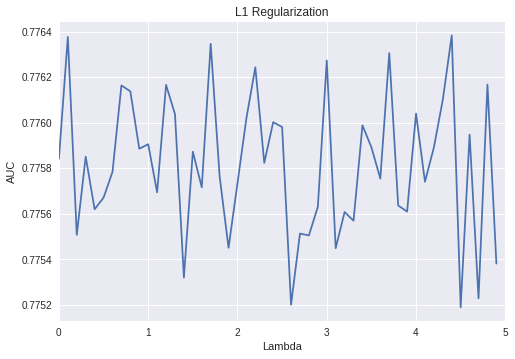

In [0]:
plt.plot(lambda_range, scores)
plt.xlim([0.0, 5])
#plt.ylim([0.0, 1.0])
plt.title('L1 Regularization')
plt.xlabel('Lambda')
plt.ylabel('AUC')
plt.grid(True)

**2-degree Polynomial Features**

In [0]:
poly = PolynomialFeatures(2)

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

In [0]:
print(X_test.shape)
print(X_test_poly.shape)

(17782, 30)
(17782, 496)


Optimal Cutoff: [0.50000056]
Accurcay: 0.4260488134068159
AUC: 0.6314739638478732
Log Loss: 0.592997208680826
Confusion Matrix:
 [[ 5007     0]
 [10206  2569]]
Recall: 0.2010958904109589
Precision: 1.0


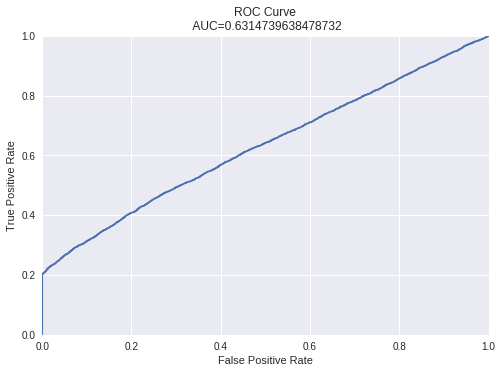

In [0]:
logreg_poly = LogisticRegression()
model_training(logreg_poly, X_train_poly, y_train)

plot_auc_curve(logreg_poly, X_test_poly, y_test)
Find_Optimal_Cutoff(logreg_poly, X_test_poly, y_test)
print_accurcay_metrics(logreg_poly, X_test_poly, y_test, 0.75)


Optimal Cutoff: [0.50000056]
Accurcay: 0.4265528779911706
AUC: 0.6291482466513103
Log Loss: 0.593985800009206
Confusion Matrix:
 [[20164     0]
 [40787 10175]]
Recall: 0.19965856912993996
Precision: 1.0


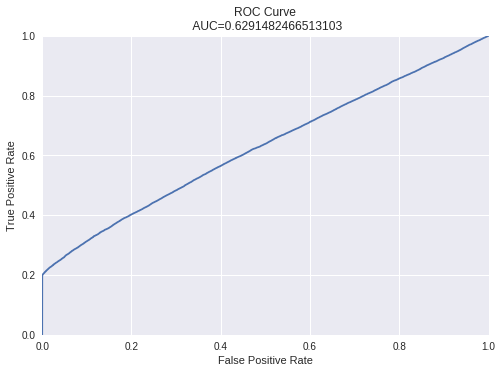

In [0]:
plot_auc_curve(logreg_poly, X_train_poly, y_train)
Find_Optimal_Cutoff(logreg_poly, X_train_poly, y_train)
print_accurcay_metrics(logreg_poly, X_train_poly, y_train, 0.75)


In [0]:
print_accurcay_metrics(logreg_poly, X_train_poly, y_train, 0.75)


Accurcay: 0.4265528779911706
AUC: 0.6291482466513103
Log Loss: 0.593985800009206
Confusion Matrix:
 [[20164     0]
 [40787 10175]]
Recall: 0.19965856912993996
Precision: 1.0


Optimal Cutoff: [0.6066277]
Accurcay: 0.707906872117872
AUC: 0.7856372976072247
Log Loss: 0.5413509330047691
Confusion Matrix:
 [[3267 1740]
 [3454 9321]]
Recall: 0.729628180039139
Precision: 0.842690534309737


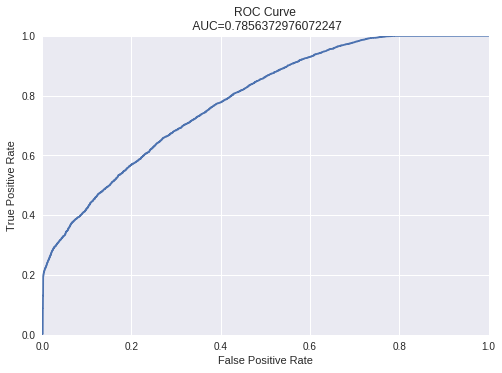

In [0]:
ridge_poly = RidgeClassifier(alpha=1.0)
model_training(ridge_poly, X_train_poly, y_train)

plot_auc_curve(ridge_poly, X_test_poly, y_test)
Find_Optimal_Cutoff(ridge_poly, X_test_poly, y_test)
print_accurcay_metrics(ridge_poly, X_test_poly, y_test, 0.6)

Optimal Cutoff: [0.72400387]
Accurcay: 0.6847373748734675
AUC: 0.7896286099656176
Log Loss: 0.4413692013788498
Confusion Matrix:
 [[3556 1451]
 [4155 8620]]
Recall: 0.6747553816046967
Precision: 0.8559229470757621


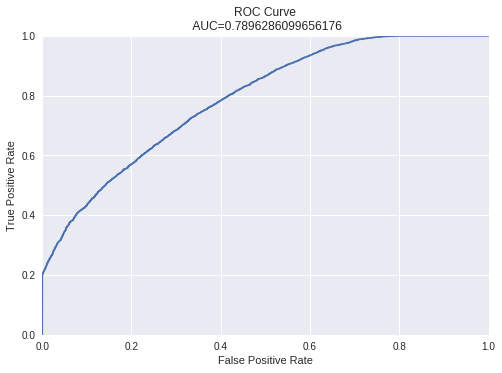

In [0]:
lasso_poly = LogisticRegression(penalty='l1', C=1)
model_training(lasso_poly, X_train_poly, y_train)

plot_auc_curve(lasso_poly, X_test_poly, y_test)
Find_Optimal_Cutoff(lasso_poly, X_test_poly, y_test)
print_accurcay_metrics(lasso_poly, X_test_poly, y_test, 0.73)

**Ranfom Forest**

In [0]:
import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 123

X = X_encoded
y = y_encoded

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 1
max_estimators = 10

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 1):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

NameError: ignored

Optimal Cutoff: [0.72]
Accurcay: 0.6750646721403667
AUC: 0.7992197928770564
Log Loss: 0.4366225859201746
Confusion Matrix:
 [[3783 1224]
 [4554 8221]]
Recall: 0.643522504892368
Precision: 0.8704076230809953


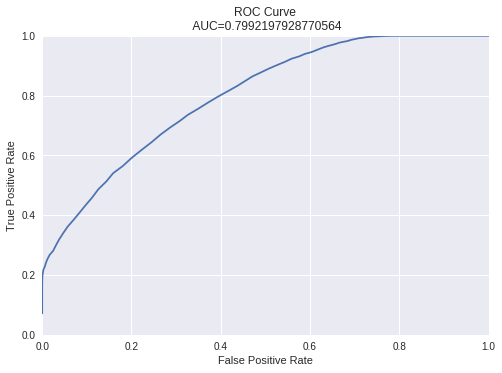

In [0]:
rf = RandomForestClassifier(n_estimators=100, 
                            criterion='gini', 
                            max_features='sqrt',
                            n_jobs=-1)
model_training(rf, X_train, y_train)

plot_auc_curve(rf, X_test, y_test)
Find_Optimal_Cutoff(rf, X_test, y_test)
print_accurcay_metrics(rf, X_test, y_test, 0.73)

Optimal Cutoff: [0.71]
Accurcay: 0.6656169159824542
AUC: 0.793600239508133
Log Loss: 0.44570862529671634
Confusion Matrix:
 [[3787 1220]
 [4726 8049]]
Recall: 0.6300587084148728
Precision: 0.8683784658539216


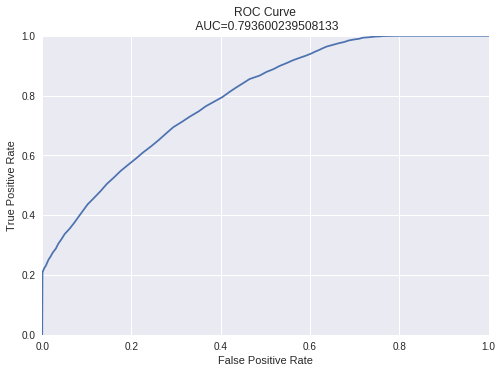

In [0]:
rf = RandomForestClassifier(n_estimators=100, 
                            criterion='gini', 
                            max_features=None,
                            n_jobs=-1)
model_training(rf, X_train, y_train)

plot_auc_curve(rf, X_test, y_test)
Find_Optimal_Cutoff(rf, X_test, y_test)
print_accurcay_metrics(rf, X_test, y_test, 0.73)

In [0]:
print_accurcay_metrics(rf, X_train, y_train, 0.73)

Accurcay: 0.9960914433540478
AUC: 1.0
Log Loss: 0.12253440514446652
Confusion Matrix:
 [[20164     0]
 [  278 50684]]
Recall: 0.9945449550645579
Precision: 1.0


**Feature Importances**

Feature ranking:
1. Credit_Score (0.205297)
2. Current_Loan_Amount (0.139297)
3. Maximum_Open_Credit (0.089153)
4. Current_Credit_Balance (0.086238)
5. Monthly_Debt (0.085836)
6. Years_of_Credit_History (0.081426)
7. Annual_Income (0.078193)
8. Number_of_Open_Accounts (0.056693)
9. Months_since_last_delinquent (0.049870)
10. Years_in_current_job (0.042165)
11. Term_Short Term (0.029044)
12. Number_of_Credit_Problems (0.008109)
13. Purpose_Debt Consolidation (0.007761)
14. Bankruptcies (0.006280)
15. Purpose_Other (0.005561)
16. Home_Ownership_Rent (0.005068)
17. Home_Ownership_Home Mortgage (0.005012)
18. Home_Ownership_Own Home (0.003948)
19. Purpose_Home Improvements (0.003886)
20. Tax_Liens (0.002601)
21. Purpose_Medical Bills (0.001904)
22. Purpose_Buy a Car (0.001521)
23. Purpose_Buy House (0.001144)
24. Purpose_small_business (0.001048)
25. Purpose_Take a Trip (0.000814)
26. Purpose_major_purchase (0.000803)
27. Purpose_moving (0.000407)
28. Purpose_wedding (0.000359)
29. Purpose

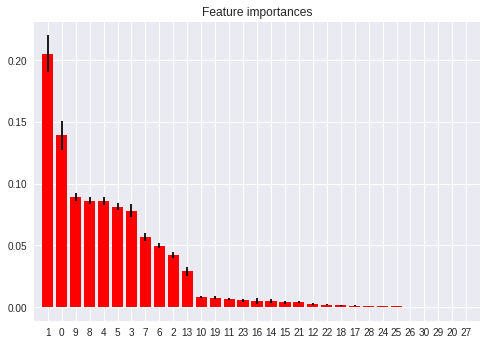

In [0]:
feature_importance(rf, X_train)

Optimal Cutoff: [0.71]
Accurcay: 0.666685412214599
AUC: 0.7938035556483155
Log Loss: 0.43725254454557444
Confusion Matrix:
 [[3788 1219]
 [4708 8067]]
Recall: 0.6314677103718199
Precision: 0.8687271160887358


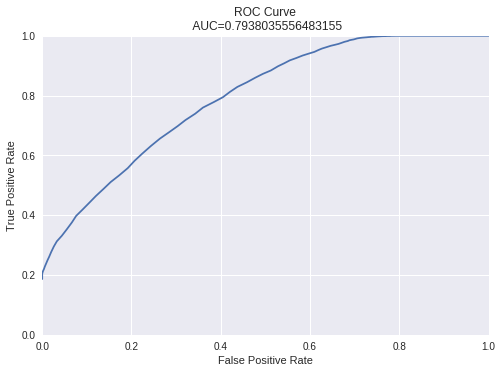

In [0]:
rf_poly = RandomForestClassifier(n_estimators=100, 
                            criterion='gini', 
                            max_features='sqrt',
                            n_jobs=-1)
model_training(rf_poly, X_train_poly, y_train)

plot_auc_curve(rf_poly, X_test_poly, y_test)
Find_Optimal_Cutoff(rf_poly, X_test_poly, y_test)
print_accurcay_metrics(rf_poly, X_test_poly, y_test, 0.73)

**Bagging**

Optimal Cutoff: [0.8]
Accurcay: 0.6507142053762232
AUC: 0.7670064961890927
Log Loss: 0.8914951669549039
Confusion Matrix:
 [[3682 1325]
 [4886 7889]]
Recall: 0.6175342465753425
Precision: 0.8561970913826785


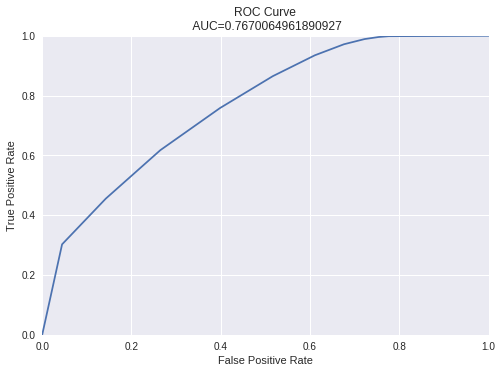

In [0]:
bagging = RandomForestClassifier(n_estimators=10, 
                            criterion='gini', 
                            max_features=None,
                            n_jobs=-1)
model_training(bagging, X_train, y_train)

plot_auc_curve(bagging, X_test, y_test)
Find_Optimal_Cutoff(bagging, X_test, y_test)
print_accurcay_metrics(bagging, X_test, y_test, 0.73)

In [0]:
print_accurcay_metrics(bagging, X_train, y_train, 0.73)

Accurcay: 0.9476843910806175
AUC: 0.9993173364891933
Log Loss: 0.12855648584544643
Confusion Matrix:
 [[20148    16]
 [ 3705 47257]]
Recall: 0.9272987716337663
Precision: 0.9996615404141899


**Boosting**

Optimal Cutoff: [0.50220576]
Accurcay: 0.2815768754920706
AUC: 0.8022008092779698
Log Loss: 0.6564135187775232
Confusion Matrix:
 [[ 5007     0]
 [12775     0]]
Recall: 0.0
Precision: 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


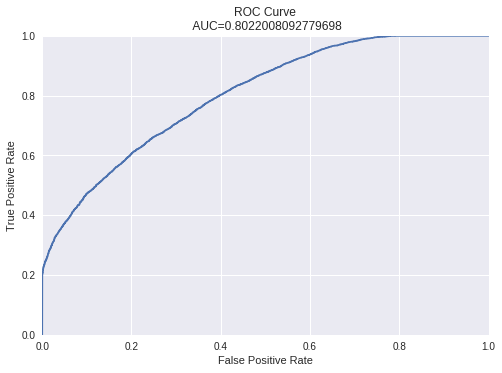

In [0]:
adaBoost = AdaBoostClassifier(n_estimators=100)
model_training(adaBoost, X_train, y_train)

plot_auc_curve(adaBoost, X_test, y_test)
Find_Optimal_Cutoff(adaBoost, X_test, y_test)
print_accurcay_metrics(adaBoost, X_test, y_test, 0.73)

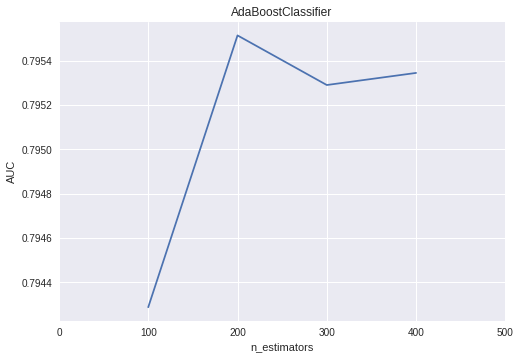

In [0]:
n_range = np.arange(100, 500, 100)
scores = []
for n in n_range:
  adaBoost = AdaBoostClassifier(n_estimators=n)
  scores.append(cross_val_score(adaBoost, X_train, y_train, cv=5, scoring='roc_auc').mean())


plt.plot(n_range, scores)
plt.xlim([0.0, 500])
#plt.ylim([0.0, 1.0])
plt.title('AdaBoostClassifier')
plt.xlabel('n_estimators')
plt.ylabel('AUC')
plt.grid(True)

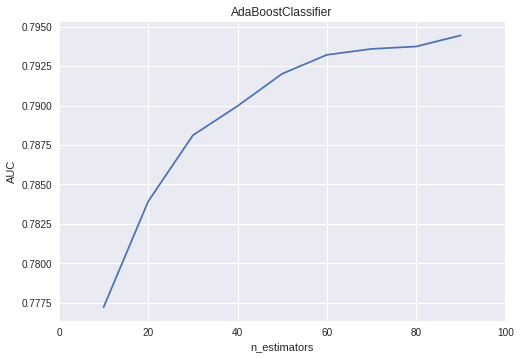

In [0]:
n_range = np.arange(10, 100, 10)
scores = []
for n in n_range:
  adaBoost = AdaBoostClassifier(n_estimators=n)
  scores.append(cross_val_score(adaBoost, X_train, y_train, cv=5, scoring='roc_auc').mean())


plt.plot(n_range, scores)
plt.xlim([0.0, 100])
#plt.ylim([0.0, 1.0])
plt.title('AdaBoostClassifier')
plt.xlabel('n_estimators')
plt.ylabel('AUC')
plt.grid(True)

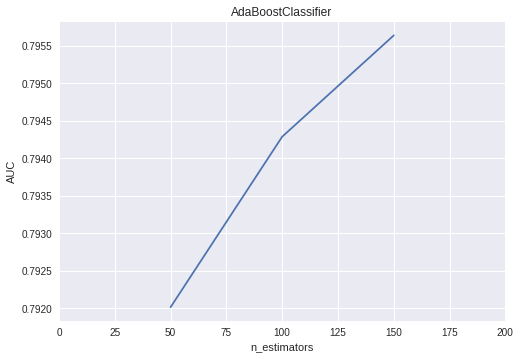

In [0]:

plt.plot(n_range, scores)
plt.xlim([0.0, 200])
#plt.ylim([0.0, 1.0])
plt.title('AdaBoostClassifier')
plt.xlabel('n_estimators')
plt.ylabel('AUC')
plt.grid(True)